📁 Choose your image source:
1️⃣  Upload from your computer
2️⃣  Use from Google Drive


Saving sample5.jpg to sample5.jpg
✅ Uploaded: sample5.jpg
📏 Loaded image size: 612x612 pixels
✅ Automatically selected ROI size: 612x612
Detected Weft Frequency: 21.00 pixels
Detected Warp Frequency: 22.00 pixels

--- FINAL RESULTS (Raw Threads) ---
Weft Threads: 21.00
Warp Threads: 22.00


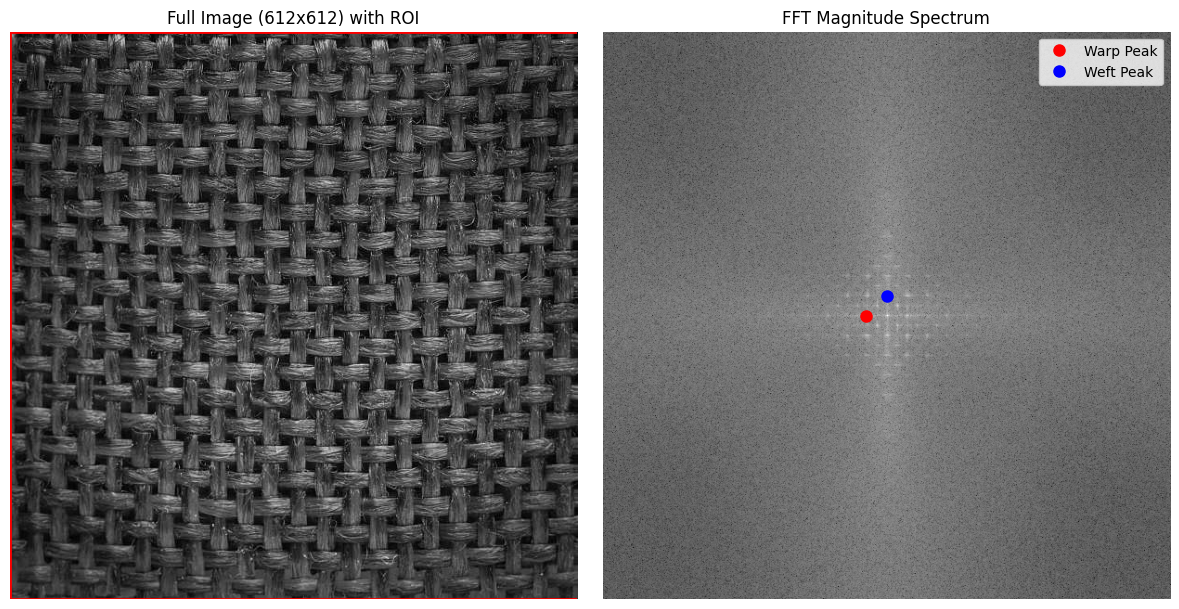

In [1]:
# --- SETUP ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import os

# --- FABRIC TPI ANALYSIS FUNCTION ---
def analyze_fabric_tpi(image_path, ppi=None):
    """Analyzes a fabric image to calculate Warp and Weft TPI (auto ROI)."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"❌ Error: Could not load image from {image_path}")
        return

    h, w = img.shape
    print(f"📏 Loaded image size: {w}x{h} pixels")

    # --- AUTO ROI SIZE ---
    roi_size = min(h, w)
    print(f"✅ Automatically selected ROI size: {roi_size}x{roi_size}")

    # Center crop for ROI
    start_h = (h - roi_size) // 2
    start_w = (w - roi_size) // 2
    roi = img[start_h : start_h + roi_size, start_w : start_w + roi_size]

    # --- FFT PROCESS ---
    f_transform = np.fft.fft2(roi)
    f_transform_shifted = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.log1p(np.abs(f_transform_shifted))

    center_x, center_y = roi_size // 2, roi_size // 2
    vertical_line = magnitude_spectrum[:, center_x]
    horizontal_line = magnitude_spectrum[center_y, :]

    smoothed_vertical_line = gaussian_filter1d(vertical_line, sigma=2)
    smoothed_horizontal_line = gaussian_filter1d(horizontal_line, sigma=2)

    weft_peaks, _ = find_peaks(smoothed_vertical_line, prominence=0.1, distance=5)
    warp_peaks, _ = find_peaks(smoothed_horizontal_line, prominence=0.1, distance=5)

    center_ignore_radius = roi_size // 50  # dynamic threshold
    weft_freq, warp_freq = 0, 0

    # --- PEAK DETECTION ---
    valid_weft = np.where(np.abs(weft_peaks - center_y) > center_ignore_radius)[0]
    if valid_weft.size > 0:
        valid_peak_locations = weft_peaks[valid_weft]
        distances = np.abs(valid_peak_locations - center_y)
        weft_freq = np.min(distances)
        weft_peak_y = valid_peak_locations[np.argmin(distances)]

    valid_warp = np.where(np.abs(warp_peaks - center_x) > center_ignore_radius)[0]
    if valid_warp.size > 0:
        valid_peak_locations = warp_peaks[valid_warp]
        distances = np.abs(valid_peak_locations - center_x)
        warp_freq = np.min(distances)
        warp_peak_x = valid_peak_locations[np.argmin(distances)]

    print(f"Detected Weft Frequency: {weft_freq:.2f} pixels")
    print(f"Detected Warp Frequency: {warp_freq:.2f} pixels")

    # --- TPI CALCULATION ---
    if ppi:
        roi_inches = roi_size / ppi
        weft_tpi = weft_freq / roi_inches
        warp_tpi = warp_freq / roi_inches
        print("\n--- FINAL RESULTS (TPI) ---")
        print(f"Weft: {weft_tpi:.2f} TPI")
        print(f"Warp: {warp_tpi:.2f} TPI")
    else:
        print("\n--- FINAL RESULTS (Raw Threads) ---")
        print(f"Weft Threads: {weft_freq:.2f}")
        print(f"Warp Threads: {warp_freq:.2f}")

    # --- VISUALIZATION ---
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Full Image ({w}x{h}) with ROI')
    plt.axis('off')
    # Draw ROI rectangle
    rect = plt.Rectangle((start_w, start_h), roi_size, roi_size,
                         edgecolor='red', facecolor='none', linewidth=2)
    plt.gca().add_patch(rect)

    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    if warp_freq > 0:
        plt.plot(warp_peak_x, center_y, 'ro', markersize=8, label='Warp Peak')
    if weft_freq > 0:
        plt.plot(center_x, weft_peak_y, 'bo', markersize=8, label='Weft Peak')
    plt.title('FFT Magnitude Spectrum')
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# --- IMAGE UPLOAD / DRIVE SELECTION ---
print("📁 Choose your image source:")
print("1️⃣  Upload from your computer")
print("2️⃣  Use from Google Drive")

from google.colab import files
uploaded = files.upload()
image_file = list(uploaded.keys())[0]
print(f"✅ Uploaded: {image_file}")

# choice = input("Enter 1 or 2: ").strip()

# if choice == "1":
#     from google.colab import files
#     uploaded = files.upload()
#     image_file = list(uploaded.keys())[0]
#     print(f"✅ Uploaded: {image_file}")

# elif choice == "2":
#     from google.colab import drive
#     drive.mount('/content/drive')
#     image_file = input("Enter full path (e.g. /content/drive/MyDrive/fabric.png): ").strip()

# else:
#     print("❌ Invalid choice! Please run again and select 1 or 2.")
#     image_file = None

# --- EXECUTION ---
ppi_value = None  # Optional: set calibration if you know your Pixels Per Inch

if image_file and os.path.exists(image_file):
    analyze_fabric_tpi(image_file, ppi=ppi_value)
else:
    print("⚠️ Image not found. Please check your path or upload again.")
